In [ ]:
# data was accessed from kaggle at the following link on 3-28-25
# https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, RocCurveDisplay, auc, roc_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import label_binarize
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(precision=10, suppress=True)


os.chdir("c:/Users/AVILA/OneDrive/Documents/GitHub/Forest-fire-prediction")

df = pd.read_csv("forest_fires.csv", low_memory = False)

### Basic summary information regarding the dataset

I have a column that indicates the day of the year that the fire was identified, but I cannot use that in the algorithm as a numeric value because the algorithm will use that as an ordinal value. Instead, I convert the "doy" column (day of the year) to a season indicator of Spring, Summer, Fall, Winter, with an even split of 91 days.

In [5]:
fires = pd.DataFrame({"doy": df["DISCOVERY_DOY"],
            "year": df["FIRE_YEAR"],
            "cause_code": df["STAT_CAUSE_CODE"],
            "cause": df["STAT_CAUSE_DESCR"],
            "fire_size": df["FIRE_SIZE"],
            "longitude": df["LONGITUDE"],
            "latitude": df["LATITUDE"],
            "state": df["STATE"]})

fires["season"] = np.where(fires["doy"] < 91, "Q1", "Q2")
fires.loc[(fires["doy"] >=91*2) & (fires["doy"] < 91*3), "season"] = "Q3"
fires.loc[(fires["doy"] >= 91*3), "season"] = "Q4"
fires.head()

,doy,year,cause_code,cause,fire_size,longitude,latitude,state,season
0,33,2005,9.0,Miscellaneous,0.10,-121.005833,40.036944,CA,Q1
1,133,2004,1.0,Lightning,0.25,-120.404444,38.933056,CA,Q2
2,152,2004,5.0,Debris Burning,0.10,-120.735556,38.984167,CA,Q2
3,180,2004,1.0,Lightning,0.10,-119.913333,38.559167,CA,Q2
4,180,2004,1.0,Lightning,0.10,-119.933056,38.559167,CA,Q2


In [6]:
fires.groupby(["cause", "season"]).count().head(12)

doy   year  cause_code  fire_size  longitude  latitude  \
cause    season                                                             
Arson    Q1      92938  92938       92938      92938      92938     92938   
         Q2      85922  85922       85922      85922      85922     85922   
         Q3      50181  50181       50181      50181      50181     50181   
         Q4      52414  52414       52414      52414      52414     52414   
Campfire Q1      12239  12239       12239      12239      12239     12239   
         Q2      22936  22936       22936      22936      22936     22936   
         Q3      28196  28196       28196      28196      28196     28196   
         Q4      12768  12768       12768      12768      12768     12768   
Children Q1      15126  15126       15126      15126      15126     15126   
         Q2      23955  23955       23955      23955      23955     23955   
         Q3      13887  13887       13887      13887      13887     13887   
         Q4       8199   8199        8199       8199       8199      8199   

                 state  
cause    season         
Arson    Q1      92938  
         Q2      85922  
         Q3      50181  
         Q4      52414  
Campfire Q1      12239  
         Q2      22936  
         Q3      28196  
         Q4      12768  
Children Q1      15126  
         Q2      23955  
         Q3      13887  
         Q4       8199

<Axes: xlabel='Count', ylabel='cause'>

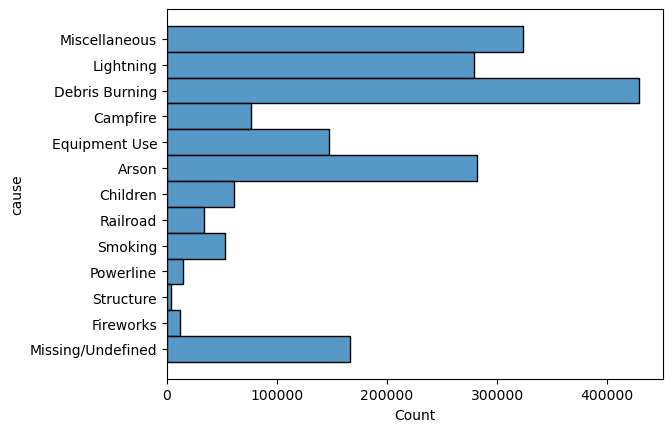

In [ ]:
sns.histplot(fires, y = "cause")

In [ ]:
mean_fire_size_state = pd.DataFrame({"mean": fires.groupby("state")["fire_size"].mean()})
std_fire_size_state = pd.DataFrame({"std": fires.groupby("state")["fire_size"].std()})
fire_size_state = mean_fire_size_state.merge(std_fire_size_state, how = "left", on = "state").reset_index().sort_values(by = "mean", ascending = False)
fire_size_state.head(10)


,state,mean,std
0,AK,2509.779198,19600.650646
33,NV,531.720650,5888.665139
13,ID,372.890482,5643.331940
32,NM,170.234318,2858.989052
51,WY,169.523555,2195.531021
26,MT,154.034541,2864.760995
48,WA,142.697410,3120.713833
37,OR,137.716104,4225.904392
45,UT,133.927628,2648.867747
29,NE,121.334348,1848.199585


# Fitting Decision Trees and Random Forest Models

The following section is broken into two parts:

1) The dataset contains a column for fire_size as measured in acres. I first fit both a Regression Decision Tree and a Regression Random Forest to predict the size of a fire given relevant features. I then tune over both the max_depth and the min_impurity_decrease parameters for both models. After training both of these models, I then fit a full decision tree and full random forest and prune these models by tuning over ccp_alpha. Finally I compare the error rates across these four models to determine the best predictive capacity. 

2) I convert the fire_size column into a category broken into four parts; small, medium, large, and extremely large fires. I then repeat the above task of fitting a Classification Decision Tree, a Classification Random Forest, and tuning over max_depth, min_impurity_decrease, and ccp_alpha to predict the size of a fire given relevant features. I then compare the error rates across these four models with the Regression task in part 1), at which point we determine which is the best model to utilize for deployment

### Regression Decision Tree, tuning over max_depth + min_impurity_decrease

In [7]:
fires_binary_copy = fires.copy()
fires_binary_copy = pd.get_dummies(fires_binary_copy, columns = ["state", "season"])
fires_binary_copy = fires_binary_copy.drop(["doy", "longitude", "latitude", "cause"], axis = 1)

# I am cutting down the size of the dataset due to the excessive time it takes to train the following models. 

fires_binary_copy = fires_binary_copy.sample(n = 100000, random_state = 20)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(fires_binary_copy.loc[:, fires_binary_copy.columns != "fire_size"],
                                                    fires_binary_copy["fire_size"], 
                                                    test_size = .3, 
                                                    shuffle = True,
                                                    random_state = 20)

tree = DecisionTreeRegressor()
impurity_decrease = np.power(np.linspace(.0001, 10, 30), 2)
depth = np.linspace(3, 20, 17).astype(int)
parameters = {"min_impurity_decrease": impurity_decrease,
              "max_depth": depth}
kfcv = KFold()
cvgs = RandomizedSearchCV(tree, parameters, cv = kfcv, n_jobs = -1, n_iter = 50, random_state = 20)

cvgs.fit(X_train, y_train)
print(cvgs.best_estimator_)

DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.47575268405469684)


In [117]:
#fitting the full decision tree on the training data validate using the test data.
tree = DecisionTreeRegressor(min_impurity_decrease = .475752684, max_depth = 3)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print("mean training error in acres:", round(np.sqrt(train_mse), 2))
print("mean test error in acres:", round(np.sqrt(test_mse), 2))

mean training error in acres: 2004.95
mean test error in acres: 1993.27


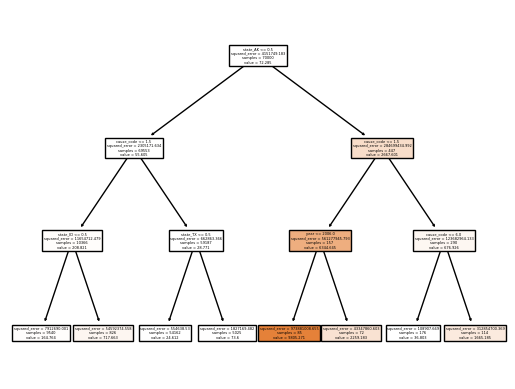

In [118]:
plot_tree(tree, filled = True, feature_names = X_train.columns)
plt.show()

The Decision Tree model as it currently stands is predicting with an average error of 1993.27 acres, which translates to approximately 3.12 square miles. 

### Fitting a full Decision Tree, tuning over ccp_alpha, and pruning

In [10]:
tree = DecisionTreeRegressor(random_state = 20)
tree.fit(X_train, y_train)

ccpp = tree.cost_complexity_pruning_path(X_train, y_train)
parameters = {"ccp_alpha": ccpp.ccp_alphas}

random_search = RandomizedSearchCV(tree, 
                                   parameters, 
                                   cv = kfcv, 
                                   n_iter = 200, 
                                   n_jobs = -1, 
                                   scoring = "neg_mean_squared_error", 
                                   random_state = 20)
random_search.fit(X_train, y_train)

print(random_search.best_estimator_)

DecisionTreeRegressor(ccp_alpha=3208.194030306935, random_state=20)


In [11]:
tree = DecisionTreeRegressor(ccp_alpha = 3208.19403, random_state = 20)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print("mean training error in acres:", round(np.sqrt(train_mse), 2))
print("mean test error in acres:", round(np.sqrt(test_mse), 2))

mean training error in acres: 1757.91
mean test error in acres: 2108.09


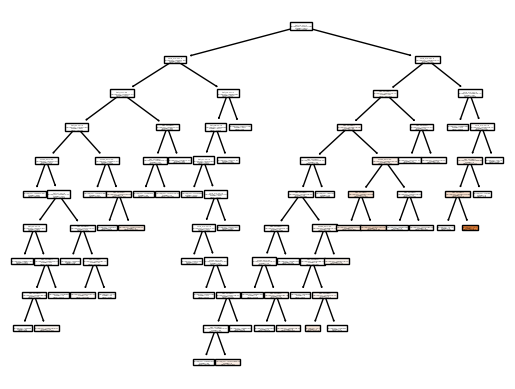

In [12]:
plot_tree(tree, filled = True, feature_names = X_train.columns)
plt.show()

### Random Forest Regression Model, tuning over max_depth + max_impurity_decrease

In [ ]:
random_forest = RandomForestRegressor(n_estimators = 30, 
                                      random_state = 20, 
                                      n_jobs = -1)
kfcv = KFold()
# I use the same paramters as the decision tree model to tune over
parameters = {"min_impurity_decrease": impurity_decrease,
              "max_depth": depth}
gscv = RandomizedSearchCV(random_forest, parameters, cv = kfcv, n_jobs = -1, n_iter = 50, random_state = 20)

gscv.fit(X_train, y_train)
print(gscv.best_estimator_)

RandomForestRegressor(max_depth=3, min_impurity_decrease=34.364337694934605,
                      n_estimators=30, n_jobs=-1, random_state=20)


In [ ]:
random_forest = RandomForestRegressor(max_depth = 3, 
                                      min_impurity_decrease = 34.36433769, 
                                      n_estimators = 30)
random_forest.fit(X_train, y_train)
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)

print("mean training error in acres:", round(np.sqrt(train_mse_rf), 2))
print("mean test error in acres:", round(np.sqrt(test_mse_rf), 2))

mean training error in acres: 2002.18
mean test error in acres: 1996.39


### Fitting a full Random Forest, tuning over ccp_alpha, and pruning

In [ ]:
random_forest = RandomForestRegressor(random_state = 20, n_estimators = 30)
random_forest.fit(X_train, y_train)


#the below captures the cost complexity pruning path for each individual tree withing the random forest.
ccp_alphas = []

print("capturing ccp_alphas")
for tree in random_forest.estimators_:
    path = tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas.extend(path.ccp_alphas)

#we then need to do grid search for each of the ccp_alphas in ccp_alphas
parameters = {"ccp_alpha": ccp_alphas}

print('conducting grid_search')
randomized_search = RandomizedSearchCV(random_forest, 
                                       parameters, 
                                       n_iter = 50, 
                                       n_jobs = -1, 
                                       random_state = 20, 
                                       cv = kfcv)
randomized_search.fit(X_train, y_train)

#if everything works right, we should get the best ccp_alpha for the entirety of the random forest model
print(randomized_search.best_estimator_)

capturing ccp_alphas
conducting grid_search
RandomForestRegressor(ccp_alpha=33.64500356481623, n_estimators=30,
                      random_state=20)


In [ ]:
random_forest = RandomForestRegressor(random_state = 20, 
                                      n_estimators = 30, 
                                      ccp_alpha = 33.64500356, 
                                      n_jobs = -1)
random_forest.fit(X_train, y_train)

y_pred_train = random_forest.predict(X_train)
y_pred_test = random_forest.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("mean squared error training data, random forest: ", round(np.sqrt(train_mse), 2))
print("mean squared error test data, random forest: ", round(np.sqrt(test_mse), 2))

mean squared error training data, random forest:  1786.72
mean squared error test data, random forest:  2114.43


** It might be worth testing a regression model, both linear and polynomial, to see if we can generate better predictions. **

In [16]:
# for this data we go back to the full fires dataset.
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# If I want to run this as a linear regression, I have to adjust the fires_binary_copy to include dummy variables for both the year and cause_code columns

fbc_expanded = pd.get_dummies(fires_binary_copy, columns = ["year"])
fbc_expanded = pd.get_dummies(fbc_expanded, columns = ["cause_code"])
labels = fbc_expanded.loc[:, "fire_size"]
features = fbc_expanded.drop("fire_size", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .3, random_state = 20, shuffle = True)

ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred = ols.predict(X_test)

print(ols.score(X_train, y_train))
print(ols.score(X_test, y_test))


0.013570273357808471
0.005266546017926421


Clearly OLS is terrible at predicting the size of the fire. This is our baseline. 

What if we broke the "fire size" into categories? In other words, instead of predicting a continuous value, we could predict small through extra large, where each category contains a range of values?

Using the data, lets create some definitions for our distinction between small, medium, large, and extra large fires:

### Preparing the data for the classification models

In [17]:
print("number of fires less than one acre: ", fires[fires["fire_size"] < 1].shape[0])
print("number of fires between one acre and 320 acres (half a square mile): ", (fires[(fires["fire_size"] >= 1) & (fires["fire_size"] < 320)]).shape[0])
print("number of fires between 320 acres and 640 acres (full square mile): ", (fires[(fires["fire_size"] >= 320) & (fires["fire_size"] < 640)]).shape[0])
print("number of fires greater than 640 acres: ", fires[fires["fire_size"] > 640].shape[0])


number of fires less than one acre:  912076
number of fires between one acre and 320 acres (half a square mile):  944663
number of fires between 320 acres and 640 acres (full square mile):  8631
number of fires greater than 640 acres:  14922


The above statistics indicate that nearly all of the fires that occur in the United States are from small to medium sized fires. But the fires that have the greatest impact are the fires that exceed one 640 acres. Therefore there is a significant interest in being able to accurately predict large and extremely large fires. 

In [18]:
fbc_expanded["fire_size_cat"] = np.where(fbc_expanded["fire_size"] < 1, "small", "medium")
fbc_expanded.loc[(fires["fire_size"] >= 320) & (fbc_expanded["fire_size"] < 640), "fire_size_cat"] = "large"
fbc_expanded.loc[fbc_expanded["fire_size"] > 640, "fire_size_cat"] = "extremely large"

Now lets run the decision trees again using the categories, instead of the numeric acerage.

### Classification Decision Tree and Random Forest, tuning over max_depth + max_impurity_decrease

In [167]:
tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators = 30, random_state = 20)

labels = fbc_expanded.loc[:, "fire_size_cat"]
labels = label_binarize(labels, classes = ["small", "medium", "large", "extremely large"])
features = fbc_expanded.drop(["fire_size", "fire_size_cat"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = .3, random_state = 20, shuffle = True)

randomized_search_tree = RandomizedSearchCV(tree, 
                                            parameters, 
                                            cv = kfcv, 
                                            n_iter = 50, 
                                            n_jobs = -1, 
                                            random_state = 20)
randomized_search_tree.fit(X_train, y_train)
print(randomized_search_tree.best_estimator_)

randomized_search_random_forest = RandomizedSearchCV(random_forest, 
                                                     parameters, 
                                                     cv = kfcv, 
                                                     n_iter = 50, 
                                                     n_jobs = -1, 
                                                     random_state = 20)
randomized_search_random_forest.fit(X_train, y_train)
print(randomized_search_random_forest.best_estimator_)


DecisionTreeClassifier(ccp_alpha=3.189374999999989e-05)
RandomForestClassifier(ccp_alpha=3.189374999999989e-05, n_estimators=30,
                       random_state=20)


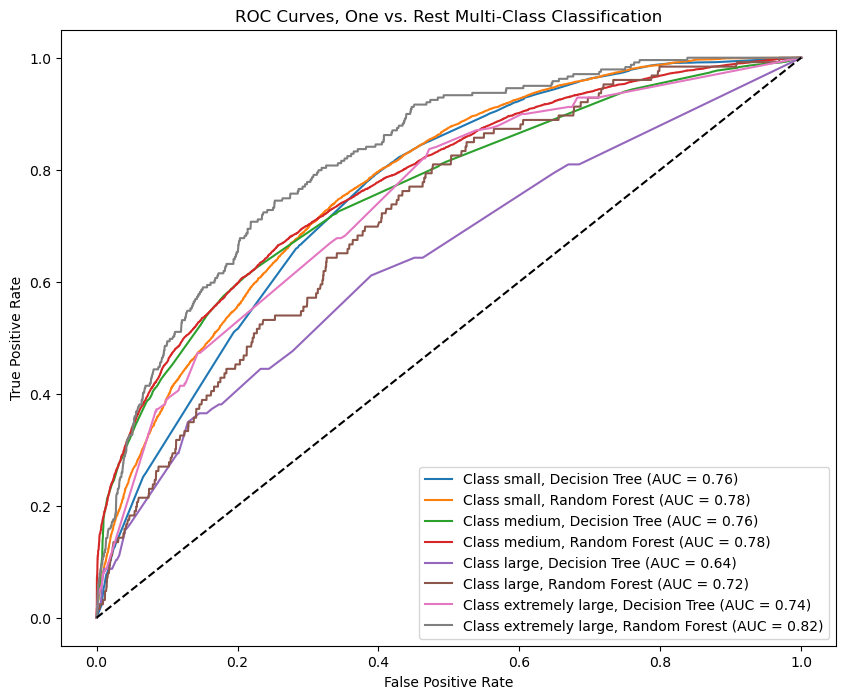

In [259]:
#fitting optimized decision tree and random forest classification models
tree = DecisionTreeClassifier(max_depth = 18, 
                              min_impurity_decrease = 0.00000001)

random_forest = RandomForestClassifier(max_depth = 18, 
                                       min_impurity_decrease = 0.00000001, 
                                       n_estimators = 30, 
                                       random_state = 20)


tree.fit(X_train, y_train)
tree_predict_proba = np.array(tree.predict_proba(X_test))

random_forest.fit(X_train, y_train)
random_forest_predict_proba = np.array(random_forest.predict_proba(X_test))

#visualizing the ROC Curves for each class, for both decision tree and random forest
fig, ax = plt.subplots(figsize=(10, 8))

# since we are displaying a multiclass one-vs-rest roc curve, we need to iterate through each binarized class in y_test 
class_names = ["small", "medium", "large", "extremely large"]
for i in range(y_test.shape[1]):
    tree_roc_display = RocCurveDisplay.from_predictions(y_test[:,i],
                                                        tree_predict_proba[i][:, 1],
                                                        name = f"Class {class_names[i]}, Decision Tree",
                                                        ax = ax)
    random_forest_roc_display = RocCurveDisplay.from_predictions(y_test[:, i],
                                                                 random_forest_predict_proba[i][:,1],
                                                                 name = f"Class {class_names[i]}, Random Forest",
                                                                 ax = ax)
  

plt.plot([0,1], [0,1], color = "black", linestyle = "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves, One vs. Rest Multi-Class Classification")
plt.legend(loc = "lower right")
plt.show()

### Classification Decision Tree and Random Forest, tuning over ccp_alpha